# Model Training and Evaluation

In [379]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import iqr
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate


import torch
import torch.nn as nn
from torch.nn import BCELoss
import torch.optim as optim
from torch.utils.data  import TensorDataset, DataLoader
import torchmetrics

import pickle
import os


## Base Models

The first set of implemented models will be based on the simplest preprocessing methods without any feature engineering. These models will act as a benchmark for all subsequent attempts. The set will include a K-Neighbors Classifier, Decision Tree, Gradient Boosting, Random Forest, Linear Discriminant Analysis, and Logistic Regression models. The models will be compared, and a feature importance plot will be plotted using the best-performing model. 

### Base Models with Iteratively Imputed Data

The models will first be implemented with the data imputed with the Iterative Imputer. The dataset is loaded below.

In [306]:
train_imputed_iterative = pd.read_pickle('../Data/Preprocessed/train_imputed_iterative.pkl')

In [307]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The models to be implemented are first defined inside a dictionary. A results list is instantiated to save the model score results. Since this is a classification problem, the metrics of interest will be *accuracy*, *precision* and *recall*. *Precision* can be viewed as the accuracy of the positive predictions, it can be calculated as follows:

$$precision = \frac{TP}{TP + FP},$$

where $TP$ is the number of true positives, and $FP$ is the number of false positives. This metric is usually reported alongside *recall*, also called *sensitivity* or the *true positive rate* (TPR). *Recall* is the ratio of positive instances that are correctly classified. *Recall* can be calculated as follows:

$$recall = \frac{TP}{TP + FN},$$

where $TP$ is the number of true positives and $FN$, the number of false negatives [(Aurelian Géron, 2023)](#ref-Geron2023).


K-Fold cross-validation (with 10 splits) is used to avoid overfitting. K=10 was chosen as it is a generally acceptable number for this method. The results from the cross-validation are stored in a pickle file for further use. 

In [308]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')


The results are now printed, and accuracy plots are presented for comparison purposes. 

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943294
                             Precision  0.951660
                             Recall     0.948087
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962754
                             Precision  0.955711
                             Recall     0.979645


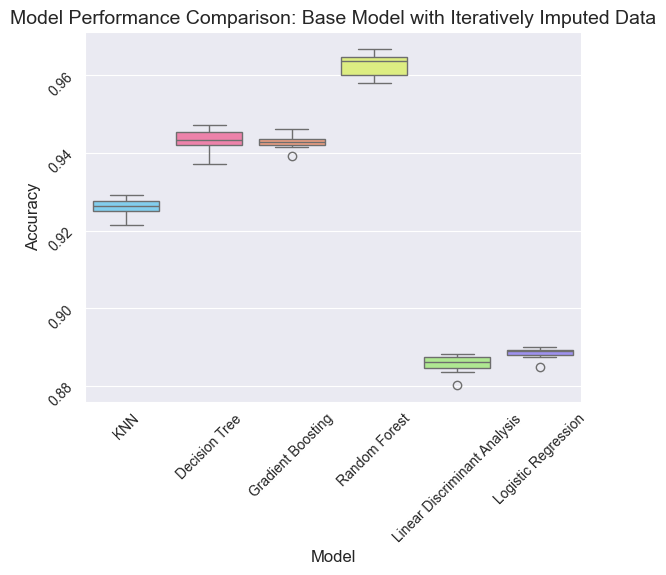

In [309]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Iteratively Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

The plot above and the comparison data frame for the results clearly show that the Random Forrest model outperformed the others. It has achieved an accuracy of 0.9627, a precision of 0.9557 and a recall of 0.9796. These results are surprisingly high for a base model.

### Base Model with KNN Imputer 

The KNN-imputed data will now be imported for the next set of model comparisons. The same steps will be undertaken as in the previous implementation.

In [310]:
train_imputed_knn = pd.read_pickle('../Data/Preprocessed/train_imputed_knn.pkl')

In [311]:
# Splitting the data into features and response:
X = train_imputed_knn.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_knn['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [312]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.944574
                             Precision  0.934158
                             Recall     0.938232
Gradient Boosting            Accuracy   0.942995
                             Precision  0.947188
                             Recall     0.919768
KNN                          Accuracy   0.924247
                             Precision  0.942093
                             Recall     0.879262
Linear Discriminant Analysis Accuracy   0.884220
                             Precision  0.865326
                             Recall     0.867871
Logistic Regression          Accuracy   0.887175
                             Precision  0.872630
                             Recall     0.866017
Random Forest                Accuracy   0.963822
                             Precision  0.974326
                             Recall     0.941348


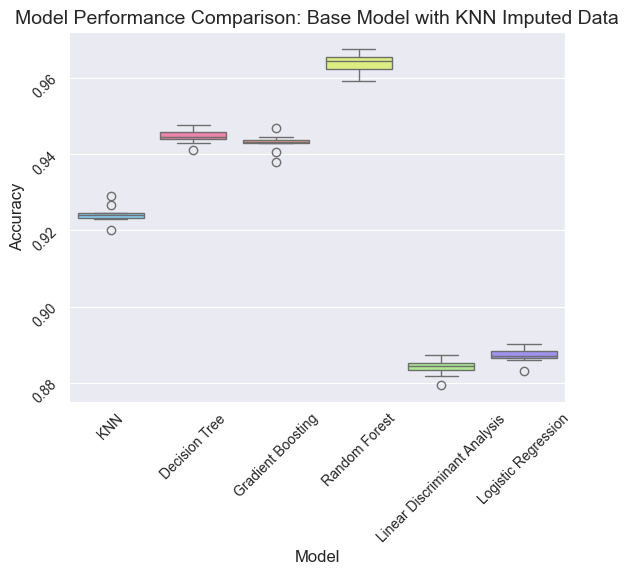

In [313]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with KNN Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Results with the KNN-imputed data are slightly better than those obtained with the Itertive Imputer. The Random Forrest algorithm obtains an accuracy score of approximately 0.9638, a precision of 0.9743, and a recall of 0.9413.

### Base Model with DropNa and Mode Imputation

Here, the data with the thrid imputation method will be imported. A reminder: entries with NaNs were dropped only for those features where the number of NaNs was less than the established threshold of 5% (of the data size). For all other features, the mode was used to impute the missing values. This imputation method assumes that the 'Non-Applicable' categories are irrelevant for response predictions.

In [314]:
# Importing the preprocessed data:
train_preprocessed_dropna_mode = pd.read_pickle('../Data/Preprocessed/train_preprocessed_dropna_mode.pkl')

In [315]:
# Splitting the data into features and response:
X = train_preprocessed_dropna_mode.drop(columns = 'Satisfaction', axis = 1)
y = train_preprocessed_dropna_mode['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [316]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945630
                             Precision  0.954313
                             Recall     0.951566
Gradient Boosting            Accuracy   0.944356
                             Precision  0.943362
                             Recall     0.961529
KNN                          Accuracy   0.937811
                             Precision  0.931738
                             Recall     0.963055
Linear Discriminant Analysis Accuracy   0.894912
                             Precision  0.912730
                             Recall     0.904835
Logistic Regression          Accuracy   0.898806
                             Precision  0.911469
                             Recall     0.913809
Random Forest                Accuracy   0.963919
                             Precision  0.957720
                             Recall     0.980927


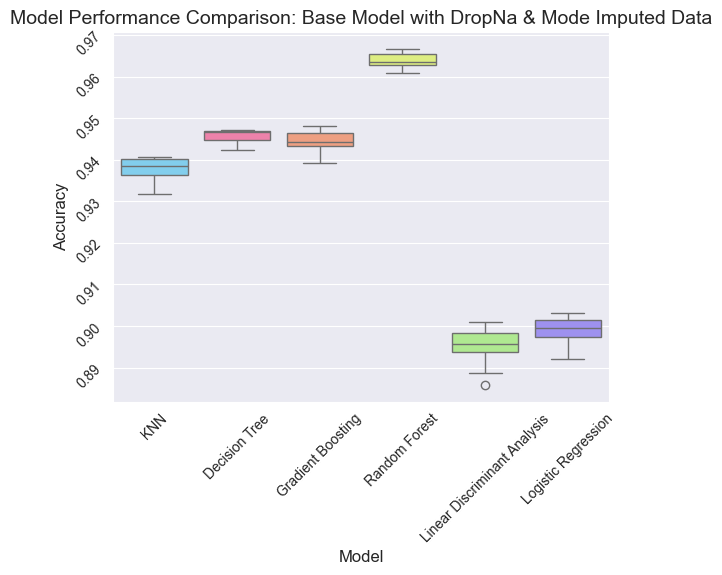

In [317]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Again, the plot looks similar to the previous two. The Random Forrest results are slightly better than those of KNN. This model reached an accuracy of 0.9639, a precision of 0.9577, and a recall of 0.9809. This suggests that dropping the NaN entries has slightly helped the model performance. 

### Base Model with Non-Applicable Category

The last model comparison will be performed using the data set where the 'Non-Applicable' entries were given a separate category in the data. The missing values for the 'Arrival Delay in Minutes' feature were computed using the Iterative Imputer, with an `initial_strategy` set to the 'mean'. 

In [318]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [319]:
# Splitting the data into features and response:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [320]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945546
                             Precision  0.953385
                             Recall     0.950359
Gradient Boosting            Accuracy   0.943987
                             Precision  0.941742
                             Recall     0.960561
KNN                          Accuracy   0.928001
                             Precision  0.914205
                             Recall     0.963335
Linear Discriminant Analysis Accuracy   0.872363
                             Precision  0.877534
                             Recall     0.900406
Logistic Regression          Accuracy   0.875616
                             Precision  0.878800
                             Recall     0.905350
Random Forest                Accuracy   0.965179
                             Precision  0.958047
                             Recall     0.981519


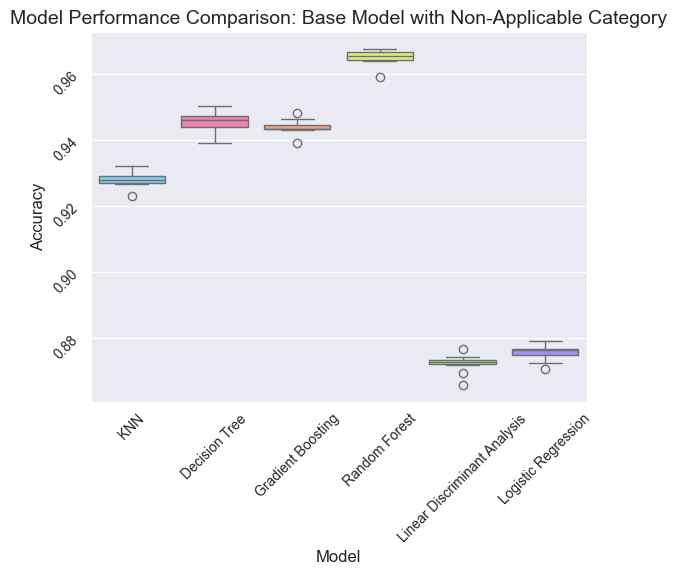

In [321]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Non-Applicable Category', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The comparison plot looks similar to all the other attempts. The Random Forrest algorithm has achieved an accuracy of 0.9652, a precision of 0.9580 and a recall of 0.9815. The results are slightly better than with the other data sets.

## Feature Engineering

Two attempts will be made with feature engineering, before proceeding to hyper-parameter tuning of the best performing model. The data for these models has been preprocessed in the `feature_engineering` notebook. 

### Feature Selection Model

In the first implementation, a dataset will be used that only includes a subset of the data. By eliminating features which do not have any impact on the response the model could potentially improve its predictive efficiency and accuracy. 

In [322]:
# Importing the preprocessed data:
train_fs = pd.read_pickle('../Data/Feature_Selection/train_fs.pkl')

In [323]:
# Splitting the data into features and response:
X = train_fs.drop(columns = 'Satisfaction', axis = 1)
y = train_fs['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [324]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Model_fs/results_fs_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.942081
                             Precision  0.950163
                             Recall     0.947460
Gradient Boosting            Accuracy   0.940397
                             Precision  0.937040
                             Recall     0.959252
KNN                          Accuracy   0.930657
                             Precision  0.915842
                             Recall     0.966426
Linear Discriminant Analysis Accuracy   0.870140
                             Precision  0.875545
                             Recall     0.898547
Logistic Regression          Accuracy   0.872825
                             Precision  0.876719
                             Recall     0.902455
Random Forest                Accuracy   0.960002
                             Precision  0.953104
                             Recall     0.977502


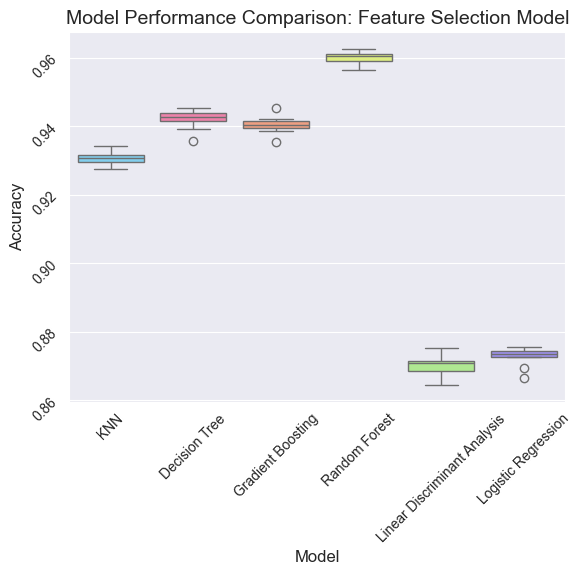

In [325]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fs/results_fs_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Selection Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The plots and results seem are worse when feature selection is performed. It seems like too much information is lost when features are excluded.

### Feature Extraction Model

The same models will be tested with two extra aggregated features, `Overall Satisfaction Score` and `Premium Service`. The relevant dataset is imported.

In [326]:
# Importing the preprocessed data:
train_oss = pd.read_pickle('../Data/Feature_Extraction/train_oss.pkl')

In [327]:
# Splitting the data into features and response:
X = train_oss.drop(columns = 'Satisfaction', axis = 1)
y = train_oss['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [328]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Model_fe/results_fe_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945565
                             Precision  0.953791
                             Recall     0.949953
Gradient Boosting            Accuracy   0.944073
                             Precision  0.941707
                             Recall     0.960767
KNN                          Accuracy   0.926634
                             Precision  0.912392
                             Recall     0.962999
Linear Discriminant Analysis Accuracy   0.871160
                             Precision  0.876867
                             Recall     0.898839
Logistic Regression          Accuracy   0.875106
                             Precision  0.878668
                             Recall     0.904479
Random Forest                Accuracy   0.964429
                             Precision  0.957307
                             Recall     0.980958


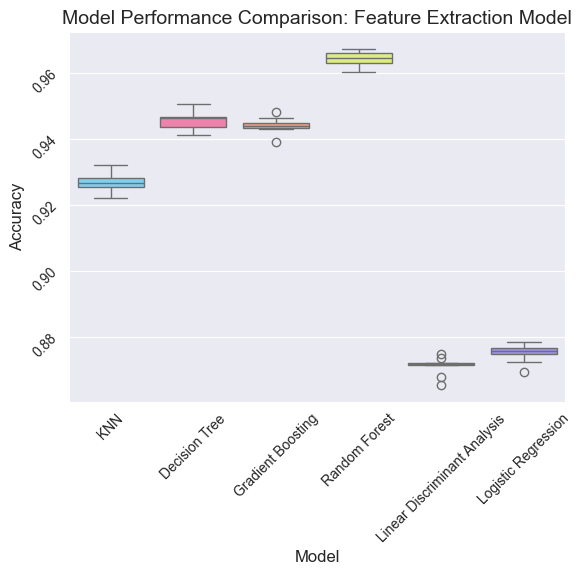

In [329]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fe/results_fe_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Extraction Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

This model has also achieved relatively good results. The Random Forest algorithm has achieved an accuracy score of 0.9644, a precision of 0.9573 and a recall of 0.9809. 

### Feature Importance Plot

The best-performing model up to now has been the 'Base Model with a Non-Applicable Category'. This model will be used to plot feature importance, that is, the most important features driving customer satisfaction outcomes.

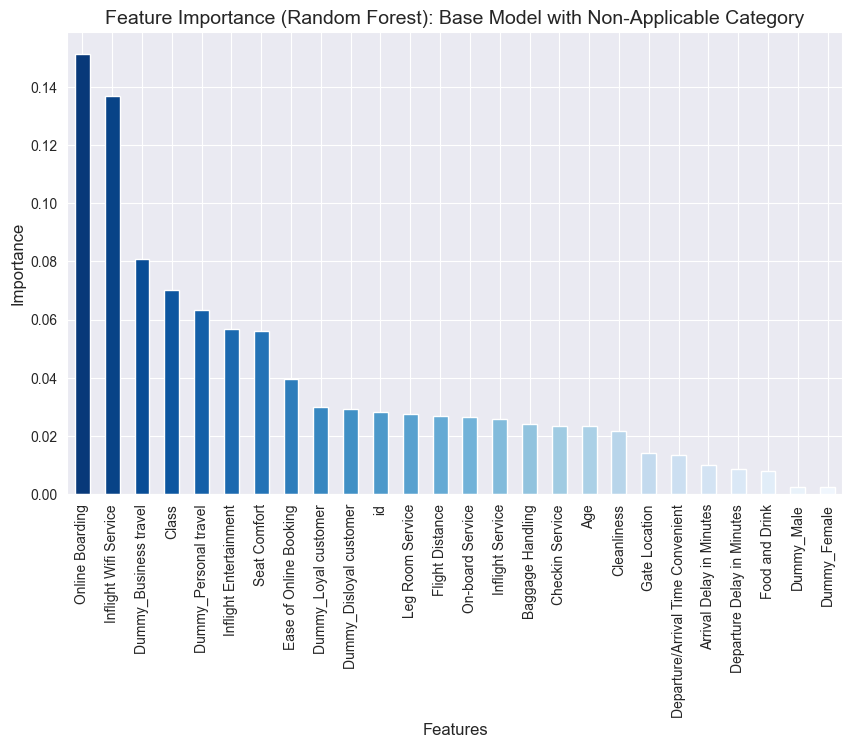

In [330]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

# Splitting the data into features and response:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting the model:
rf = RandomForestClassifier()
# model_rf = rf.fit(X_scaled, y)
model_pkl_file = '../Models/Imputation_Model_4/model_rf.pkl'
# with open(model_pkl_file, 'wb') as file:  
         # pickle.dump(model_rf, file)

with open(model_pkl_file, 'rb') as file:
        model_rf = pickle.load(file)

# Plotting the feature importance:
importance = pd.Series(model_rf.feature_importances_, index=X.columns)
colors = list(reversed(sns.color_palette("Blues", len(importance))))
ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
# Customising the plot:
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.set_title('Feature Importance (Random Forest): Base Model with Non-Applicable Category', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
plt.show()


The plot shows that the main features driving customer satisfaction are `Online Boarding`, `Inflight Wifi Service` and whether the travel was for Business purposes(`Dummy_Business travel`). Unsurprisingly, the sex of the passenger has the least impact on customer satisfaction.

## Deep Neural Network

Through simple feature engineering it wa snot possible to improve the model's performance substantially. The next model to be implemented will be a deep neural network using PyTorch. These machine learning models can perform feature engineering with raw data. The data with the 'Non-Applicable' category will be used in this neural network, since it provided the best results using standard machine learning algorithms. 

In [331]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

non_applicable_imputed.shape

(103904, 27)

All necessary procedures are carried out below in order to be able to use the data in a neural network. 

In [340]:
# Splitting the data into features and response:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encoding the target:
encoder = LabelEncoder()
encoder.fit(y)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Creating the train_dataset and the trainloader:
train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train_encoded).reshape(-1, 1).float())
trainloader = DataLoader(train_dataset, batch_size = 1000, shuffle = True)

# Creating the test_dataset and the validationloader:
test_dataset = TensorDataset(torch.tensor(X_test_scaled).float(), torch.tensor(y_test_encoded).reshape(-1, 1).float())
testloader = DataLoader(test_dataset, batch_size = 1000, shuffle = True)

The model, criteria, optimizer and metrics are all defined prior to setting up the training and validation loop. 

In [572]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary')

### Overfitting the Training Data to Validate the Model

To ensure that the model is capable of solving the underlying classification task, a small sample of the training set is overfit. That is, an accuracy of 1 and a loss close to 0 are achieved. This simple task is performed below, with the metrics of interest printed also.

Accuracy: 1.0
Loss: 0.006945597939193249


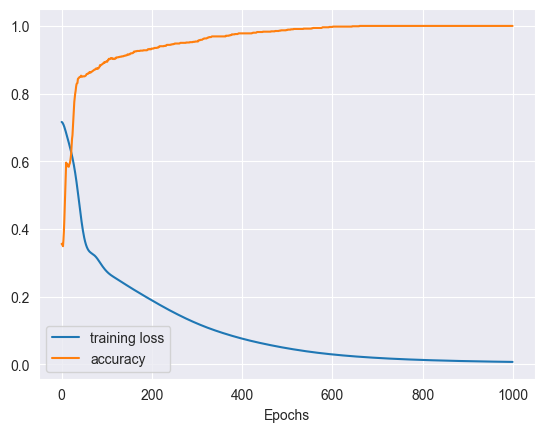

In [573]:
# Setting the trainig loss to zero:
training_loss = []
accuracy_store = []


# Taking one batch from the trainloader:
feature, target = next(iter(trainloader))

# Performing the training loop on the batch:
for i in range(int(1000)):
    
    # Runing the forward pass:
    prediction = model(feature)
    # Calculating accuracy over batch:
    accuracy = metric(prediction, target)
    accuracy_store.append(accuracy.item())
    # Calculating the loss:
    loss = criterion(prediction, target)
    # Store the loss value for plotting
    training_loss.append(loss.item())
    # Zeroing the gradient:
    optimizer.zero_grad()
    # Getting the gradients:
    loss.backward()
    # Updating the parameters:
    optimizer.step()

print('Accuracy:', accuracy.item())
print('Loss:', loss.item())

# Resetting the metrics:
metric.reset() 
 
plt.plot(training_loss)
plt.plot(accuracy_store)
plt.xlabel('Epochs')
plt.legend(['training loss', 'accuracy'])
plt.show()

The graph clearly shows that the model can overfit the small training set and achieve an accuracy of 1 and a loss close to 0. 

### Reducing the Overfitting

It is now possible to focus on reducing the overfitting and achieving the best possible validation score (on the test dataset). The same model used to overfit a small sample of the training set is now used on the whole training set. 

In [500]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)

A function is created for 100 epochs, which will be used repeatedly to test different model parameters. This iterative process aims to find achieve the highest accuracy and lowest loss on the validation set.

In [504]:
def run_100_epochs():
    # Set the number of epochs
    epochs = 100

    # Instantiating metric results for plotting:
    epoch_train_loss_storage = []
    epoch_test_loss_storage = []
    epoch_train_accuracy_storage = []
    epoch_test_accuracy_storage = []

    # Building the epoch loop:
    for epoch in range(epochs):
        
        # Setting the model to training mode:
        model.train()

        # Setting the training loss and accuracy to 0:
        training_loss = 0
        training_accuracy = 0

        # Building a loop for the train set data loader:
        for i, data in enumerate(trainloader, 0):
            
            # Starting a training loop:
            model.train()
            # Setting the gradients to zero:
            optimizer.zero_grad()
            # Getting the feature and target from the data loader:
            feature, target = data
            # Runing the forward pass:
            prediction = model(feature)
            # Calculating the loss:
            loss = criterion(prediction, target)
            # Storing the loss values for plotting:
            training_loss += loss.item()
            # Calculating accuracy over the batch:
            accuracy = metric(prediction, target)
            training_accuracy += accuracy.item()
            # Getting the gradients:
            loss.backward()
            # Updating the parameters:
            optimizer.step()

        # Storing the results of interest for plotting:
        epoch_train_loss = training_loss / len(trainloader)
        epoch_train_loss_storage.append(epoch_train_loss)
        epoch_train_accuracy = training_accuracy / len(trainloader)
        epoch_train_accuracy_storage.append(epoch_train_accuracy)

        # Setting the validation loss and accuracy to 0:
        validation_loss = 0
        validation_accuracy = 0

        # Setting the model to evaluation mode:
        model.eval()

         # Building a loop for the trest set data loader:
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):

                # Starting an evaluation loop:
                model.eval()
                # Getting the feature and target from the data loader:
                feature, target = data
                # Running the forward pass:
                prediction = model(feature)
                # Calculating the loss:
                loss = criterion(prediction, target)
                # Calculating accuracy over batch:
                accuracy = metric(prediction, target)
                validation_accuracy += accuracy.item()
                validation_loss += loss.item()

        # Storing the results of interest for plotting:
        epoch_test_loss = validation_loss / len(testloader)
        epoch_test_loss_storage.append(epoch_test_loss)
        epoch_test_accuracy = validation_accuracy / len(testloader)
        epoch_test_accuracy_storage.append(epoch_test_accuracy)

        # Setting the model back to training mode:
        model.train()

        # Printing out what's happening every 10 epochs:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.5f}| Test loss: {epoch_test_loss:.5f}")

    # Resetting the metrics:
    metric.reset() 
    print('\nMaximum validation accuracy:', max(epoch_test_accuracy_storage))

In [505]:
# Running the model:
run_100_epochs()

Epoch: 0 | Train Loss: 0.52351| Test loss: 0.34236
Epoch: 10 | Train Loss: 0.14796| Test loss: 0.15006
Epoch: 20 | Train Loss: 0.12382| Test loss: 0.12816
Epoch: 30 | Train Loss: 0.10942| Test loss: 0.12002
Epoch: 40 | Train Loss: 0.10236| Test loss: 0.11326
Epoch: 50 | Train Loss: 0.09701| Test loss: 0.10806
Epoch: 60 | Train Loss: 0.09109| Test loss: 0.10581
Epoch: 70 | Train Loss: 0.08770| Test loss: 0.10657
Epoch: 80 | Train Loss: 0.08535| Test loss: 0.10543
Epoch: 90 | Train Loss: 0.08321| Test loss: 0.10439

Maximum validation accuracy: 0.9567768853157759


A higher accuracy score than those achieved with the simple machine learning models, has been achieved using a simple neural network. Numerous attempts will be made to improve this score even further.

A function will be defined to plot the model loss scores on both the training and validation sets. This function will most likely be used several times throughout the report.

In [506]:
def plot_loss():    
    plt.plot(epoch_train_loss_storage)
    plt.plot(epoch_test_loss_storage)
    plt.legend(['training loss', 'validation loss'])
    plt.xlabel('Epoch')
    plt.title('Training and Validation Loss')
    plt.show()

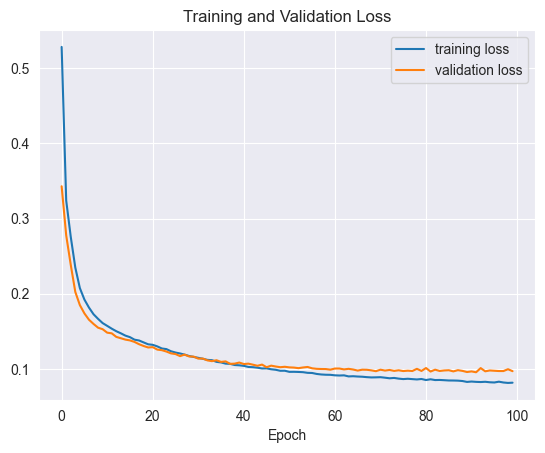

In [507]:
plot_loss()

The graph shows that the training and validation loss decrease substantially after the first 5 epochs. Overfitting seems to begin after 40 epochs, where the training loss decreases faster than the validation loss.

A function to plot the accuracy is also defined below. 

In [508]:
def plot_accuracy():
    plt.plot(epoch_train_accuracy_storage)
    plt.plot(epoch_test_accuracy_storage)
    plt.legend(['training accuracy', 'validation accuracy'])
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')
    plt.show()


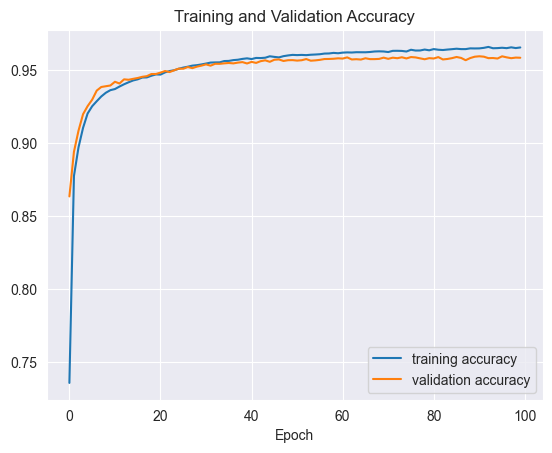

In [509]:
plot_accuracy()

Again, the accuracy seems to increase exponentially in the first 5 epochs, the rate of increase than drops dramatically. 

In the following model a Dropout layer is added after the activation function to help with 'regularisation'. This layer acts differently during training and evaluation. The probability is set to 50%.

In [510]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)

In [511]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.51867| Test loss: 0.34009
Epoch: 10 | Train Loss: 0.15626| Test loss: 0.14749
Epoch: 20 | Train Loss: 0.12845| Test loss: 0.12538
Epoch: 30 | Train Loss: 0.11313| Test loss: 0.11435
Epoch: 40 | Train Loss: 0.10280| Test loss: 0.10425
Epoch: 50 | Train Loss: 0.09500| Test loss: 0.10004
Epoch: 60 | Train Loss: 0.09064| Test loss: 0.09710
Epoch: 70 | Train Loss: 0.08768| Test loss: 0.09568
Epoch: 80 | Train Loss: 0.08563| Test loss: 0.09465
Epoch: 90 | Train Loss: 0.08287| Test loss: 0.09405

Maximum validation accuracy: 0.9611678794026375


This has helped a higher accurracy score than using other model parameters. Next, a weight_decay is also added.

In [541]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [542]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.38935| Test loss: 0.23431
Epoch: 10 | Train Loss: 0.10682| Test loss: 0.10695
Epoch: 20 | Train Loss: 0.09112| Test loss: 0.09644
Epoch: 30 | Train Loss: 0.08412| Test loss: 0.09178
Epoch: 40 | Train Loss: 0.07935| Test loss: 0.09268
Epoch: 50 | Train Loss: 0.07846| Test loss: 0.09289
Epoch: 60 | Train Loss: 0.07521| Test loss: 0.09144
Epoch: 70 | Train Loss: 0.07341| Test loss: 0.09205
Epoch: 80 | Train Loss: 0.07156| Test loss: 0.09514
Epoch: 90 | Train Loss: 0.06997| Test loss: 0.09699

Maximum validation accuracy: 0.9626678749918938


In [545]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [526]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.39839| Test loss: 0.25521
Epoch: 10 | Train Loss: 0.13805| Test loss: 0.11442
Epoch: 20 | Train Loss: 0.11307| Test loss: 0.09908
Epoch: 30 | Train Loss: 0.10353| Test loss: 0.09196
Epoch: 40 | Train Loss: 0.09766| Test loss: 0.09103
Epoch: 50 | Train Loss: 0.09628| Test loss: 0.08698
Epoch: 60 | Train Loss: 0.09337| Test loss: 0.08767
Epoch: 70 | Train Loss: 0.09258| Test loss: 0.08530
Epoch: 80 | Train Loss: 0.09154| Test loss: 0.08412
Epoch: 90 | Train Loss: 0.08991| Test loss: 0.08490

Maximum validation accuracy: 0.9641678761690855


In [531]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [532]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.38835| Test loss: 0.25318
Epoch: 10 | Train Loss: 0.13489| Test loss: 0.11244
Epoch: 20 | Train Loss: 0.10950| Test loss: 0.09602
Epoch: 30 | Train Loss: 0.10029| Test loss: 0.08966
Epoch: 40 | Train Loss: 0.09544| Test loss: 0.09037
Epoch: 50 | Train Loss: 0.09271| Test loss: 0.08631
Epoch: 60 | Train Loss: 0.08890| Test loss: 0.08558
Epoch: 70 | Train Loss: 0.08765| Test loss: 0.08630
Epoch: 80 | Train Loss: 0.08697| Test loss: 0.08393
Epoch: 90 | Train Loss: 0.08563| Test loss: 0.08304

Maximum validation accuracy: 0.9648045040667057


In [546]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [547]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.38286| Test loss: 0.24989
Epoch: 10 | Train Loss: 0.13238| Test loss: 0.11258
Epoch: 20 | Train Loss: 0.10863| Test loss: 0.09691
Epoch: 30 | Train Loss: 0.09806| Test loss: 0.09114
Epoch: 40 | Train Loss: 0.09427| Test loss: 0.08804
Epoch: 50 | Train Loss: 0.09018| Test loss: 0.08743
Epoch: 60 | Train Loss: 0.08868| Test loss: 0.08510
Epoch: 70 | Train Loss: 0.08563| Test loss: 0.08390
Epoch: 80 | Train Loss: 0.08524| Test loss: 0.08314
Epoch: 90 | Train Loss: 0.08457| Test loss: 0.08334

Maximum validation accuracy: 0.9650116302073002


In [552]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [553]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.43162| Test loss: 0.26603
Epoch: 10 | Train Loss: 0.12147| Test loss: 0.10346
Epoch: 20 | Train Loss: 0.09942| Test loss: 0.09169
Epoch: 30 | Train Loss: 0.09117| Test loss: 0.08730
Epoch: 40 | Train Loss: 0.08775| Test loss: 0.08588
Epoch: 50 | Train Loss: 0.08450| Test loss: 0.08393
Epoch: 60 | Train Loss: 0.08346| Test loss: 0.08183
Epoch: 70 | Train Loss: 0.08004| Test loss: 0.08274
Epoch: 80 | Train Loss: 0.08087| Test loss: 0.08281
Epoch: 90 | Train Loss: 0.07893| Test loss: 0.08405

Maximum validation accuracy: 0.9652049392461777


In [554]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [555]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.43342| Test loss: 0.26978
Epoch: 10 | Train Loss: 0.12004| Test loss: 0.10669
Epoch: 20 | Train Loss: 0.09826| Test loss: 0.09033
Epoch: 30 | Train Loss: 0.09086| Test loss: 0.08508
Epoch: 40 | Train Loss: 0.08705| Test loss: 0.08402
Epoch: 50 | Train Loss: 0.08535| Test loss: 0.08514
Epoch: 60 | Train Loss: 0.08210| Test loss: 0.08358
Epoch: 70 | Train Loss: 0.08012| Test loss: 0.08161
Epoch: 80 | Train Loss: 0.07847| Test loss: 0.08294
Epoch: 90 | Train Loss: 0.07738| Test loss: 0.08226

Maximum validation accuracy: 0.9657361917197704


In [562]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 400),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(400, 300),
                      nn.ReLU(),
                      nn.Linear(300, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [563]:
run_100_epochs()

Epoch: 0 | Train Loss: 0.50305| Test loss: 0.28610
Epoch: 10 | Train Loss: 0.11815| Test loss: 0.10222
Epoch: 20 | Train Loss: 0.09939| Test loss: 0.08962
Epoch: 30 | Train Loss: 0.08917| Test loss: 0.09005
Epoch: 40 | Train Loss: 0.08462| Test loss: 0.08698
Epoch: 50 | Train Loss: 0.08080| Test loss: 0.08551
Epoch: 60 | Train Loss: 0.07917| Test loss: 0.08352
Epoch: 70 | Train Loss: 0.07778| Test loss: 0.08357
Epoch: 80 | Train Loss: 0.07642| Test loss: 0.08233
Epoch: 90 | Train Loss: 0.07584| Test loss: 0.08459

Maximum validation accuracy: 0.96547238714993


## References

1. <a id="ref-Geron2023"></a>Aurelian Géron, Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd Edition), O'Reilly Media Inc, 20 January 2023.